In [1]:
import copy
import os
from abc import ABC
from typing import Optional, Any

import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt

from helpers import starfilter, is_ascending


def stds_from_quantiles(quantiles: npt.NDArray):
    num_quantiles = quantiles.shape[1]
    if num_quantiles < 50:
        print(f"warning: {num_quantiles} quantiles are too few to compute a reliable std from (should be about 100)"
        )
    return np.std(quantiles, ddof=1, axis=1)

def pis_from_quantiles(quantiles):
    mid = len(quantiles) // 2
    first, second = quantiles[:mid], quantiles[mid:]
    pi_limits = zip(first, reversed(second))
    pis = [high - low for low, high in pi_limits]
    return sorted(pis)

def quantiles_from_pis(pis: npt.NDArray, check_order=False):
    if check_order:
        assert np.all([is_ascending(pi[0, :], reversed(pi[1, :])) for pi in pis])
    y_quantiles = np.array([sorted(pi.flatten()) for pi in pis])
    return y_quantiles


# PLOTTING


def plot_data(X_train, X_test, y_train, y_test, figsize=(16, 5), ylabel="energy data", save_plot=True, filename="data.png", plots_path=".",):
    num_train_steps = X_train.shape[0]
    num_test_steps = X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_test = x_plot_train + num_test_steps

    plt.figure(figsize=figsize)
    plt.plot(x_plot_train, y_train)
    plt.plot(x_plot_test, y_test)
    plt.ylabel(ylabel)
    plt.legend(["Training data", "Test data"])
    if save_plot:
        filepath = os.path.join(plots_path, filename)
        plt.savefig(filepath)
    plt.show()


def plot_uq_results_all(X_train, y_train, X_test, y, uq_results, quantiles, output_uq_on_train: bool, save_plots=True, plots_path=".",):
    for res_type, results in uq_results.items():
        if results:
            print(f"plotting {res_type} results...")
        else:
            continue
        # todo: allow results to have multiple PIs (corresp. to multiple alphas)?
        for method_name, (y_preds, y_quantiles, y_std) in results.items():
            if y_quantiles is None and y_std is None:
                print(f"warning: cannot plot method {method_name}, because both y_quantiles and y_std are None")
                continue
            uq_type, *method_name_parts = method_name.split("_")
            plot_uq_result(X_train, X_test, y_train, y, y_preds, y_quantiles, y_std, quantiles, output_uq_on_train, plot_name=" ".join(method_name_parts), uq_type=uq_type, save_plot=save_plots, plots_path=plots_path, )


def plot_uq_result(X_train, X_test, y_train, y, y_preds, y_quantiles, y_std, quantiles, output_uq_on_train, plot_name, uq_type, save_plot=True, plots_path=".",):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = x_plot_train + num_test_steps  # shifting
    x_plot_uq = x_plot_full if output_uq_on_train else x_plot_test

    drawing_std = y_quantiles is not None
    if drawing_std:
        ci_low, ci_high = (y_quantiles[:, 0], y_quantiles[:, -1], )
        drawn_quantile = round(max(quantiles) - min(quantiles), 2)
    else:
        ci_low, ci_high = y_preds - y_std / 2, y_preds + y_std / 2

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )
    ax.plot(
        x_plot_uq, y_preds, label=f"mean/median prediction {plot_name}",  # todo: mean or median?
        color="green", )
    # noinspection PyUnboundLocalVariable
    label = rf"{plot_name} {f'{100*drawn_quantile}% CI' if drawing_std else '1 std'}"
    ax.fill_between(x_plot_uq.ravel(), ci_low, ci_high, color="green", alpha=0.2, label=label, )
    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")
    ax.set_title(f"{plot_name} ({uq_type})")
    if save_plot:
        filename = f"{plot_name}_{uq_type}.png"
        filepath = os.path.join(plots_path, filename)
        plt.savefig(filepath)
    plt.show()

In [9]:
import numpy as np

import pandas as pd

from scipy.stats import randint, norm
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from helpers import get_data, IO_Helper

from conformal_prediction import (train_base_model as train_base_model_cp, estimate_pred_interals_no_pfit_enbpi,)
from quantile_regression import estimate_quantiles as estimate_quantiles_qr

import torch

from laplace import Laplace


METHOD_WHITELIST = [
    # "posthoc_conformal_prediction",
    "posthoc_laplace",
    # "native_quantile_regression", # "native_gp",
]
QUANTILES = [0.05, 0.25, 0.75, 0.95]  # todo: how to handle 0.5? ==> just use mean if needed

PLOT_DATA = False
PLOT_RESULTS = True  # todo: fix plotting timing?
SAVE_PLOTS = False

PLOTS_PATH = "plots"

BASE_MODEL_PARAMS = {
    'skip_training': True,
    # 'n_jobs': -1, # 'model_params_choices': None,
}

torch.set_default_dtype(torch.float32)

data shapes: (100, 7) (100, 7) (100, 1) (100, 1)


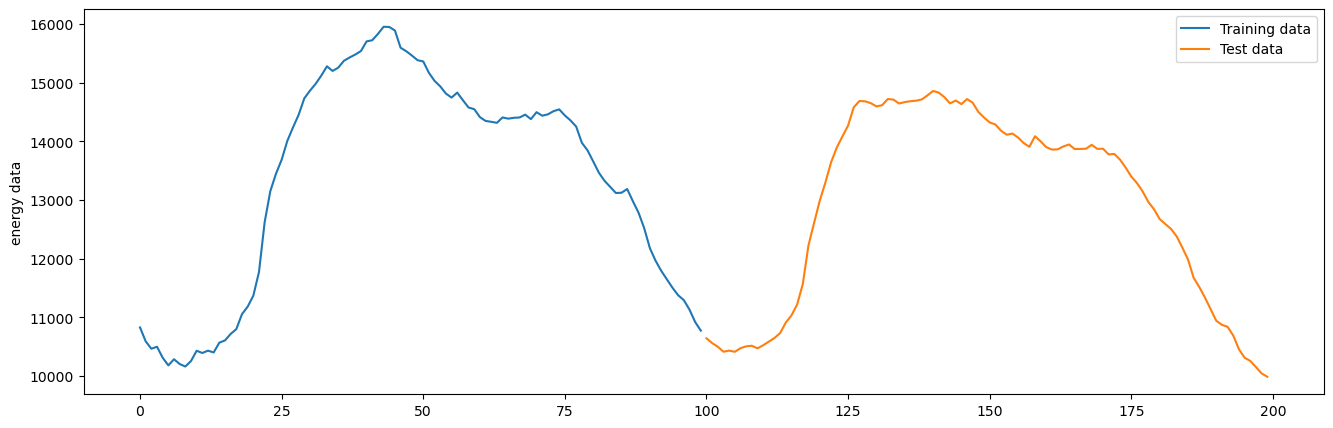

In [26]:
# uq_metrics = uq_comparer.compare_methods(
#     QUANTILES,
#     should_plot_data=PLOT_DATA,
#     should_plot_results=PLOT_RESULTS,
#     should_save_plots=SAVE_PLOTS,
#     plots_path=PLOTS_PATH,
#     base_model_params=BASE_MODEL_PARAMS,
#     output_uq_on_train=True,
#     return_results=False,
# )

X_train, X_test, y_train, y_test, X, y = get_data(100, return_full_data=True)
print("data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plot_data(X_train, X_test, y_train, y_test, save_plot=False, plots_path=None, )

In [57]:
output_uq_on_train = True
quantiles = [0.05, 0.25, 0.75, 0.95]
skip_deepcopy = True
base_model_params = {
    'skip_training': True,
    # 'n_jobs': -1,
    # 'model_params_choices': None,
}

skip_training = False
random_state = 711
N_EPOCHS = 1000
batch_size = 1
model_filename="_laplace_base.pth"

verbose = True
hidden_layer_size = 1


def _df_to_tensor(df: pd.DataFrame, dtype=float) -> torch.Tensor:
    return torch.Tensor(df.to_numpy(dtype=dtype))

def _get_train_loader(X_train, y_train, batch_size):
    X_train, y_train = map(lambda df: _df_to_tensor(df, dtype=float), (X_train, y_train))
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    return train_loader


torch.manual_seed(random_state)

def train_base_model():
    dim_in, dim_out = X_train.shape[-1], y_train.shape[-1]
    # model = torch.nn.Sequential(
    #     torch.nn.Linear(dim_in, 50), torch.nn.Tanh(), torch.nn.Linear(50, dim_out)
    # )
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in, hidden_layer_size),
        torch.nn.Linear(hidden_layer_size, dim_out)
    )
    model = model.float()
    
    train_loader = _get_train_loader(X_train, y_train, batch_size)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    iterable = tqdm(range(N_EPOCHS)) if verbose else range(N_EPOCHS)
    for _ in iterable:
        for loaded_X, loaded_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(loaded_X), loaded_y)
            loss.backward()
            optimizer.step()
    model.eval()
    base_model = model
    return base_model

base_model = train_base_model()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


In [58]:
def quantiles_gaussian(quantiles, y_pred, y_std):
    return np.array([norm.ppf(quantiles, loc=mean, scale=std) for mean, std in zip(y_pred, y_std)])

def laplace():
    X_uq = np.row_stack((X_train, X_test)) if output_uq_on_train else X_test
    # uq_results = self.run_all_methods(X_train, y_train, X_uq, quantiles=quantiles, skip_deepcopy=True, base_model_params=base_model_params, )
    
    base_model_copy = (copy.deepcopy(base_model) if not skip_deepcopy else base_model)
    # def posthoc_laplace(self, X_train: pd.DataFrame, y_train: pd.DataFrame, X_uq: pd.DataFrame, quantiles, model, N_EPOCHS=1000, batch_size=1, random_state=711, verbose=True, ):
    train_loader = _get_train_loader(X_train, y_train, batch_size)
    
    la = Laplace(model, "regression")
    la.fit(train_loader)
    log_prior, log_sigma = (torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True), )
    hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
    iterable = tqdm(range(N_EPOCHS)) if verbose else range(N_EPOCHS)
    for _ in iterable:
        hyper_optimizer.zero_grad()
        neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
        neg_marglik.backward()
        hyper_optimizer.step()
    
    X_uq_tensor = torch.Tensor(X_uq.astype("float32"))
    f_mu, f_var = la(X_uq_tensor)
    
    f_mu = f_mu.squeeze().detach().cpu().numpy()
    f_sigma = f_var.squeeze().detach().sqrt().cpu().numpy()
    pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item() ** 2)
    
    y_pred, y_std = f_mu, pred_std
    y_quantiles = quantiles_gaussian(quantiles, y_pred, y_std)
       
    uq_results = y_pred, y_quantiles, y_std
    return uq_results

uq_results = laplace()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.41it/s]


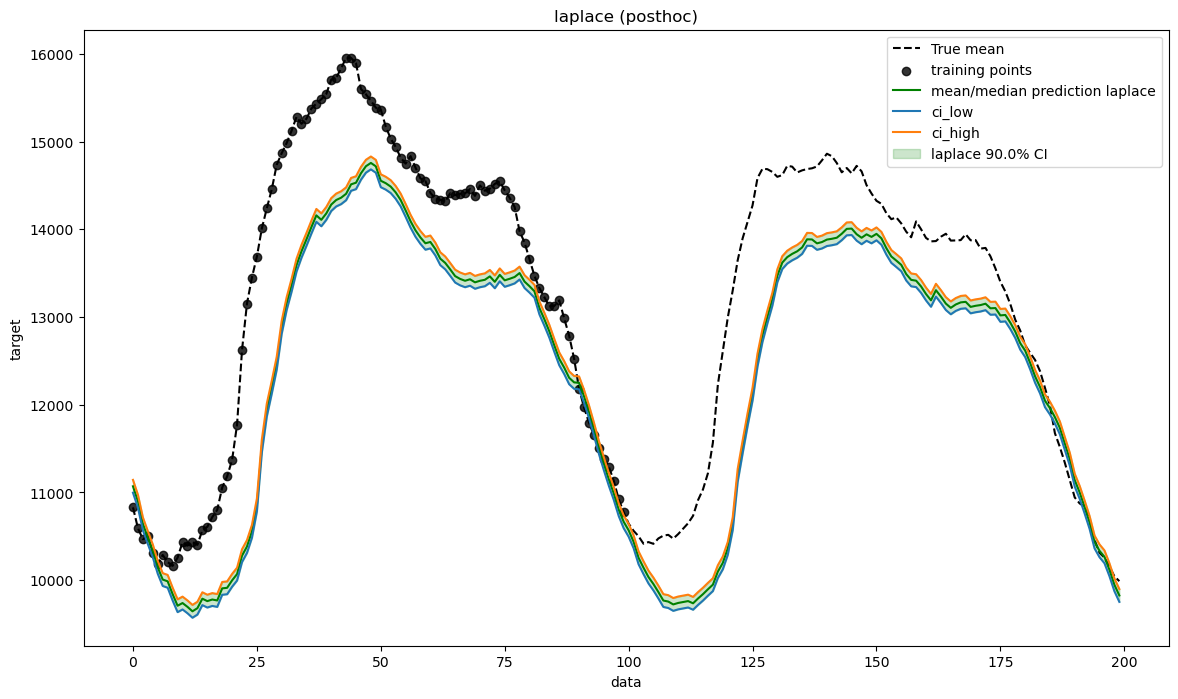

In [59]:
should_save_plots = False
plots_path = None
output_uq_on_train = True
plot_name = 'laplace'
uq_type = 'posthoc'
drawing_std = True

y_preds, y_quantiles, y_std = uq_results

num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

x_plot_train = np.arange(num_train_steps)
x_plot_full = np.arange(num_train_steps + num_test_steps)
x_plot_test = x_plot_train + num_test_steps  # shifting
x_plot_uq = x_plot_full if output_uq_on_train else x_plot_test

if not drawing_std:
    ci_low, ci_high = (y_quantiles[:, 0], y_quantiles[:, -1], )
    drawn_quantile = round(max(quantiles) - min(quantiles), 2)
else:
    ci_low, ci_high = y_preds - y_std / 2, y_preds + y_std / 2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )
ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction {plot_name}", color="green", )

ax.plot(x_plot_uq, ci_low, label="ci_low")
ax.plot(x_plot_uq, ci_high, label="ci_high")

ax.fill_between(x_plot_uq.ravel(), ci_low, ci_high, color="green", alpha=0.2, label=rf"{plot_name} {f'{100*drawn_quantile}% CI' if drawing_std else '1 std'}")

ax.legend()
ax.set_xlabel("data")
ax.set_ylabel("target")
ax.set_title(f"{plot_name} ({uq_type})")
plt.show()